# Isotherm processing

This notebook will process isotherms selected previously to generate KPI values for each one. To run this notebook the root directory must be the main folder.

In [3]:
import json
import pathlib
import pickle
from collections import Counter

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import pygaps

In [28]:
# Database location
db_path = pathlib.Path.cwd() / "data" / "iso.db"

# Get all isotherms
isotherms = pygaps.db_get_isotherms(db_path, {})

print(f'Loaded {len(isotherms)} isotherms.')

Selected20913isotherms
Loaded 20913 isotherms.


Load isotherms from JSON files.

In [3]:
iso_path = r"./data/isotherms"
paths = pygaps.util_get_file_paths(iso_path, '.json')
isotherms = [pygaps.isotherm_from_jsonf(path) for path in paths]
print("Selected isotherms:", len(isotherms))

Selected isotherms: 5755


Compute uptake values on pre-determined pressures. Do not extrapolate above maximum range. If any value below minimum range, use Henry constant to compute loading.

In [30]:
no_loading_possible = []
model_possible = []

for iso in tqdm(isotherms):

    iso.uptake = {}

    prange = np.arange(0.5, 20.5, 0.5)
    minp = min(iso.pressure(branch='ads'))
    maxp = max(iso.pressure(branch='ads'))
    model = [a for a in prange if a < minp]
    direct = [a for a in prange if minp < a < maxp]

    try:
        for p in direct:
            iso.uptake[p] = np.asscalar(iso.loading_at(p))
    except Exception:
        no_loading_possible.append(iso)
        continue
    # Take the data between 0 and x from the henry model
    if model:
        for p in model:
            iso.uptake[p] = iso.henry_k * p
        model_possible.append(iso)

    iso.uptake[0] = 0.  # we automatically include 0

0%|          | 0/20913 [00:00<?, ?it/s]C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()
100%|██████████| 20913/20913 [01:53<00:00, 183.56it/s]


In [31]:
simple_dict = {}

for iso in tqdm(isotherms):

    addition = {
        'mat' : iso.material,
        'ads' : str(iso.adsorbate),
        't' : iso.temperature,
        'type' : iso.iso_type,
        'kH' : np.log(iso.henry_k),
    }
    for p in np.arange(0.5, 20.5, 0.5):

        addition[p] = iso.uptake.get(p, None)

    simple_dict[iso.filename] = addition

df = pd.DataFrame.from_dict(simple_dict, orient='index')
df.to_hdf(pathlib.Path.cwd() / 'data' / 'kpi.h5', 'table', mode='w')

100%|██████████| 20913/20913 [00:00<00:00, 40234.00it/s]
C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\pandas\io\pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\pandas\io\pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_items] [items->None]

  f(store)


## New methods

In [252]:
df = pd.read_hdf(pathlib.Path.cwd() / 'data' / 'kpi.h5', 'table')

In [371]:
df.sample(n=500, random_state=1).to_hdf(pathlib.Path.cwd() / 'data' / 'kpi-smol.h5', 'table', mode='w')

C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\pandas\io\pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\pandas\io\pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_items] [items->None]

  f(store)


In [253]:
len(df['mat'].unique())

4413

In [254]:
# select on experiment
select = None
if select:
    dft = df[df['type']==select]
else:
    dft = df

# select on temperature
t_val = 303
t_mar = 10
dft = dft[dft['t'].between(t_val - t_mar, t_val + t_mar)]

# create two clean dataframes with only material
g1 = dft[dft['ads'] == 'nitrogen'].drop(['type', 't', 'ads'], axis=1).reset_index()
g2 = dft[dft['ads'] == 'carbon dioxide'].drop(['type', 't', 'ads'], axis=1).reset_index()

# select only common materials
common = list(set(g1['mat'].unique()).intersection(g2['mat'].unique()))
g1 = g1[g1['mat'].isin(common)]
g2 = g2[g2['mat'].isin(common)]

print(len(g1))
print(len(g2))

756
1459


In [21]:
def no_mean(x):
    return np.mean(x)

grouped1 = g1.groupby('mat')
grouped2 = g2.groupby('mat')

def iqr(x):    
    q75, q25 = np.nanpercentile(sorted(x), [75, 25], interpolation='linear')
    iqr = q75 - q25
    l_b = q25 - (1.5 * iqr)
    u_b = q75 + (1.5 * iqr)

    Q1 = df['nb'].quantile(0.25)
    Q3 = df['nb'].quantile(0.75)
    IQR = Q3 - Q1


group1 = grouped1.aggregate([len, np.median, np.std])
group2 = grouped2.aggregate([len, np.median, np.std])

# grouped1.aggregate(
#     nKh=pd.NamedAgg(column='kH', aggfunc=len),
#     mKh=pd.NamedAgg(column='kH', aggfunc=np.mean),
#     eKh=pd.NamedAgg(column='kH', aggfunc=no_mean),
#     p1=pd.NamedAgg(column='kH', aggfunc=np.sum),
#     )

# grouped1.get_group('CuBTC')

group1.merge(group2, on=('mat'), suffixes=('_1', '_2'))

kH_1                     0.5_1  \
                                       len    median       std   len   
mat                                                                    
(Hbzza)2]*H2O*C2H5OH                   2.0  0.526242  0.398136   2.0   
1-pyr                                  1.0  0.109336       NaN   1.0   
1K-HKUST-1                             1.0  0.001533       NaN   1.0   
2% -COOH Functionalized CMK-5 d = 6nm  1.0  0.037498       NaN   1.0   
2% -COOH Functionalized CMK-5 d = 8nm  1.0  0.035366       NaN   1.0   
...                                    ...       ...       ...   ...   
{Ag3[Ag5(mu3-3,5-tBu2tz)6](BF4)2}n     1.0  0.023694       NaN   1.0   
{[Co(dcpy)(bipy)0.5(H2O)]*H2O}         1.0  0.379619       NaN   1.0   
{[Ni(Hptz)2] 7H2O}n                    1.0  3.832100       NaN   1.0   
{[Zn(bpydb)(bpy)](DMA)-(EtOH)6}n       1.0  0.480174       NaN   1.0   
{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O}         1.0  0.206778       NaN   1.0   

                                                         1.0_1            \
                                         median      std   len    median   
mat                                                                        
(Hbzza)2]*H2O*C2H5OH                   0.255987  0.18608   2.0  0.373966   
1-pyr                                  0.001275      NaN   1.0       NaN   
1K-HKUST-1                             0.000767      NaN   1.0  0.001533   
2% -COOH Functionalized CMK-5 d = 6nm  0.018749      NaN   1.0  0.024696   
2% -COOH Functionalized CMK-5 d = 8nm  0.017683      NaN   1.0  0.012973   
...                                         ...      ...   ...       ...   
{Ag3[Ag5(mu3-3,5-tBu2tz)6](BF4)2}n     0.015326      NaN   1.0  0.033717   
{[Co(dcpy)(bipy)0.5(H2O)]*H2O}         0.090265      NaN   1.0       NaN   
{[Ni(Hptz)2] 7H2O}n                    0.059726      NaN   1.0  0.114385   
{[Zn(bpydb)(bpy)](DMA)-(EtOH)6}n       0.163045      NaN   1.0  0.299617   
{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O}         0.063057      NaN   1.0  0.204486   

                                                1.5_1  ...   18.5_2 19.0_2  \
                                            std   len  ...      std    len   
mat                                                    ...                   
(Hbzza)2]*H2O*C2H5OH                   0.270588   2.0  ...      NaN    2.0   
1-pyr                                       NaN   1.0  ...  0.06397    2.0   
1K-HKUST-1                                  NaN   1.0  ...      NaN    1.0   
2% -COOH Functionalized CMK-5 d = 6nm       NaN   1.0  ...      NaN    1.0   
2% -COOH Functionalized CMK-5 d = 8nm       NaN   1.0  ...      NaN    1.0   
...                                         ...   ...  ...      ...    ...   
{Ag3[Ag5(mu3-3,5-tBu2tz)6](BF4)2}n          NaN   1.0  ...      NaN    2.0   
{[Co(dcpy)(bipy)0.5(H2O)]*H2O}              NaN   1.0  ...      NaN    1.0   
{[Ni(Hptz)2] 7H2O}n                         NaN   1.0  ...      NaN    1.0   
{[Zn(bpydb)(bpy)](DMA)-(EtOH)6}n            NaN   1.0  ...      NaN    1.0   
{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O}              NaN   1.0  ...      NaN    1.0   

                                                         19.5_2            \
                                         median      std    len    median   
mat                                                                         
(Hbzza)2]*H2O*C2H5OH                        NaN      NaN    2.0       NaN   
1-pyr                                  0.447293  0.06353    2.0  0.452599   
1K-HKUST-1                                  NaN      NaN    1.0       NaN   
2% -COOH Functionalized CMK-5 d = 6nm  4.775230      NaN    1.0  4.863173   
2% -COOH Functionalized CMK-5 d = 8nm  4.530185      NaN    1.0  4.598165   
...                                         ...      ...    ...       ...   
{Ag3[Ag5(mu3-3,5-tBu2tz)6](BF4)2}n          NaN      NaN    2.0       NaN   
{[Co(dcpy)(bipy)0.5(H2O)]*H2O}              NaN      NaN    1.0       NaN   
{[Ni(Hptz)2] 7H2O}n     

In [146]:
test = pd.DataFrame({'iso': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k'],
                   'mat': ['co2', 'co2', 'co2', 'n2', 'co2', 'n2', 'ch4', 'n2', 'co2', 'co2'],
                   'kH': np.random.randn(10)})

def func(x):

    l = len(x)

    if l == 1:
        return float(x)

    if l == 2:
        return np.average(x)

    elif 2 < l <= 4:
        return np.average(x)

    elif 4 < l:

        # Computing IQR
        Q3, Q1 = np.nanpercentile(sorted(x), [75, 25], interpolation='linear')
        IQR = Q3 - Q1
                
        return np.mean((Q1 - 1.5 * IQR < x ) | ( x > Q3 + 1.5 * IQR))

    else:
        raise Exception('Not good.')

# print(test)
test.groupby('mat').agg(func)

6.32 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [305]:
np.array([0,1,2,3]) - np.array([1,1,1,1])

array([-1,  0,  1,  2])

In [301]:
def process(x):

    no_nan = x.dropna()

    l = len(no_nan)
    
    if l == 0:
        return (0, np.nan, 0)

    elif l == 1:
        return (1, float(no_nan), 0)

    elif l == 2:
        return (l, np.average(no_nan), np.std(no_nan))

    elif 2 < l <= 4:
        return (l, np.average(no_nan), np.std(no_nan))

    elif 4 < l:
        Q1 = no_nan.quantile(0.25)
        Q3 = no_nan.quantile(0.75)
        IQR = Q3 - Q1
        
        removed = no_nan[(Q1 - 1.5 * IQR < no_nan) & ( no_nan < Q3 + 1.5 * IQR)]

        return (len(removed), np.mean(removed), np.std(removed))

    else:
        raise Exception

import time
start_time = time.time()

final = pd.merge(dft[dft['ads'] == 'nitrogen'].drop(
            ['type', 't', 'ads'], axis=1).reset_index().groupby('mat', sort=False).agg(process),
         dft[dft['ads'] == 'carbon dioxide'].drop(
            ['type', 't', 'ads'], axis=1).reset_index().groupby('mat', sort=False).agg(process),
            on=('mat'), suffixes=('_x', '_y'))

print("--- %s seconds ---" % (time.time() - start_time))

--- 29.64663791656494 seconds ---


In [331]:
a = (0, 1, 3)
b = (2, 2, 2)

np.array(list(max(elem[0], elem[1]) for elem in zip(a, b)))

array([2, 2, 3])

In [362]:
lp, p1, p2 = 0.5, 1, 5

K_nx = np.array([e[0] for e in final['kH_x']])
K_x = np.array([e[1] for e in final['kH_x']])
K_ny = np.array([e[0] for e in final['kH_y']])
K_y = np.array([e[2] for e in final['kH_y']])
K_n = K_nx + K_ny

L_nx = np.array([e[0] for e in final['{0:.1f}_x'.format(lp)]])
L_x = np.array([e[1] for e in final['{0:.1f}_x'.format(lp)]])
L_ny = np.array([e[0] for e in final['{0:.1f}_y'.format(lp)]])
L_y = np.array([e[1] for e in final['{0:.1f}_y'.format(lp)]])
L_n = L_nx + L_ny

W_nx1 = np.array([e[0] for e in final['{0:.1f}_x'.format(p1)]])
W_x1 = np.array([e[1] for e in final['{0:.1f}_x'.format(p1)]])
W_nx2 = np.array([e[0] for e in final['{0:.1f}_x'.format(p2)]])
W_x2 = np.array([e[1] for e in final['{0:.1f}_x'.format(p2)]])
W_ny1 = np.array([e[0] for e in final['{0:.1f}_y'.format(p1)]])
W_y1 = np.array([e[1] for e in final['{0:.1f}_y'.format(p1)]])
W_ny2 = np.array([e[0] for e in final['{0:.1f}_y'.format(p2)]])
W_y2 = np.array([e[1] for e in final['{0:.1f}_y'.format(p2)]])

W_x = W_x2 - W_x1
W_y = W_y2 - W_y1
W_nx = np.maximum(W_nx1, W_nx2)
W_ny = np.maximum(W_ny1, W_ny2)
W_n = W_nx + W_ny

sel = K_y / K_x
psa_W = (K_y / W_x) * sel

ret_dict = {
    'labels': final.index,

    # parameters
    'sel': sel,
    'psa_W': psa_W,

    # Henry data
    'K_x': K_x, 'K_y': K_y,
    'K_nx': K_nx, 'K_ny': K_ny, 'K_n': K_n,

    # Loading data
    'L_x': L_x, 'L_y': L_y,
    'L_nx': L_nx, 'L_ny': L_ny, 'L_n': L_n,

    # Working capacity data
    'W_x': W_x, 'W_y': W_y,
    'W_nx': W_nx, 'W_ny': W_ny, 'W_n': W_n,
}


In [367]:
final.loc['CuBTC', 'kH_x'][2]

0.36256445419738215

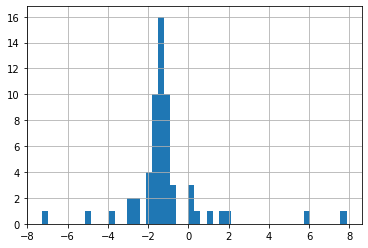

In [261]:
dft[(dft['mat']=='CuBTC') & (dft['ads']=='nitrogen')]['kH'].hist(bins=50)

In [260]:
x = dft[(dft['mat']=='CuBTC') & (dft['ads']=='nitrogen')]['kH']
Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

print(np.std(x))
np.std(x[(Q1 - 1.5 * IQR < x) & ( x < Q3 + 1.5 * IQR)])

2.007282109337619


0.36256445419738215

In [61]:
# import time
# start_time = time.time()
# print("--- %s seconds ---" % (time.time() - start_time))

# g1 = dft[dft['ads'] == 'nitrogen'].drop(
#             ['type', 't', 'ads'], axis=1).reset_index().groupby('mat').agg(lambda x: tuple(x))
# g2 = dft[dft['ads'] == 'carbon dioxide'].drop(
#             ['type', 't', 'ads'], axis=1).reset_index().groupby('mat').agg(lambda x: tuple(x))

pd.merge(dft[dft['ads'] == 'nitrogen'].drop(
            ['type', 't', 'ads'], axis=1).reset_index().groupby('mat', sort=False).agg(lambda x: tuple(x)),
         dft[dft['ads'] == 'carbon dioxide'].drop(
            ['type', 't', 'ads'], axis=1).reset_index().groupby('mat', sort=False).agg(lambda x: tuple(x)), 
            on=('mat'), suffixes=('_x', '_y'))

,index_x,kH_x,0.5_x,1.0_x,1.5_x,2.0_x,2.5_x,3.0_x,3.5_x,4.0_x,...,15.5_y,16.0_y,16.5_y,17.0_y,17.5_y,18.0_y,18.5_y,19.0_y,19.5_y,20.0_y
mat,,,,,,,,,,,,,,,,,,,,,
NH2-MIL-53(Al),"(10.1002adfm.201200084.Isotherm8, 10.1002ceat....","(0.00020210650202326857, 0.03783325084453814)","(0.00010105325101163429, 0.01891662542226907)","(0.00020210650202326857, 0.03783325084453814)","(0.0003031597530349029, 0.056749876266807206)","(0.00040421300404653714, 0.07566650168907628)","(0.0005052662550581714, 0.09458312711134535)","(0.0006063195060698058, 0.11349975253361441)","(0.00070737275708144, 0.13241637795588349)","(0.0008084260080930743, 0.18242927403674175)",...,"(1.1777932045205852, 8.699773839782756, 2.5796...","(1.1968789046049892, 4.536204809523815, 2.5866...","(1.2139959267789466, 4.944115083904217, 2.5937...","(1.2297175156014797, 5.396393381937024, 2.6014...","(1.245439104424013, 5.848671679969831, 2.63072...","(1.2611606932465462, 9.123215310594382, 2.6600...","(1.2768822820690793, 8.425902437847617, 2.6893...","(1.2926038708916125, 7.728589565100849, 2.7186...","(1.3083254597141458, 7.82355594934654, 2.82575...","(1.3219865096562438, 8.743139519441515, 2.9523..."
Zeolite Na-LSX,"(10.1002Aic.10306.Isotherm1, 10.1002Aic.10306....","(0.2697611366633586, 0.25368915953889465, 0.17...","(0.1348805683316793, 0.12684457976944732, 0.08...","(0.378409, nan, nan, 0.2632578, 0.276531919193...","(0.46912899999999996, 0.4448864, 0.34286633333...","(0.582576, 0.5416668, 0.42853566666666665, 0.4...","(0.71875, 0.6758206666666667, 0.514205, 0.4990...","(0.84734775, 0.847348, 0.5928034, 0.574621, 0....","(0.9683692500000001, 0.953219, 0.6714018, 0.67...","(1.07727, 1.05909, 0.7530304, 0.7681816, 1.068...",...,"(6.1730496093466165, 5.852302585774375, 6.3503...","(6.181438235845269, 5.864548657789012, 6.35169...","(6.18982686234392, 5.876610126255114, 6.352394...","(6.196557710673113, 5.88282340256601, 6.353092...","(6.202771916697657, 5.889036678876907, 6.35379...","(6.208986122722202, 5.895249955187802, 6.35449...","(6.215200328746746, 5.901463231498699, 6.35537...","(6.221414534771291, 5.907676507809595, 6.36282...","(6.227628740795835, 5.913889784120491, 6.37027...","(6.2338429468203795, 5.920103060431387, 6.3777..."
CuBTC,"(10.1002Aic.11298.Isotherm1, 10.1002Aic.11298....","(0.3244085727725127, 0.36774388341788317, 0.30...","(0.165483, 0.17891095386023803, 0.148316435041...","(0.3216852178312594, 0.3142415902218004, nan, ...","(nan, nan, nan, 0.2856779875709975, 0.40746227...","(nan, nan, nan, 0.38090398342799664, 0.5049744...","(nan, nan, nan, 0.5163531145090713, 0.60118442...","(nan, nan, nan, 0.6088709374108855, 0.69739438...","(nan, nan, nan, 0.7057631319739157, 0.79360434...","(nan, nan, nan, 0.8031505659869579, 0.88981430...",...,"(1.1941010978993316, nan, nan, nan, nan, nan, ...","(1.2219748926505076, nan, nan, nan, nan, nan, ...","(1.2521341145905762, nan, nan, nan, nan, nan, ...","(1.2855658548400317, nan, nan, nan, nan, nan, ...","(1.3189975950894874, nan, nan, nan, nan, nan, ...","(1.350616095759337, nan, nan, nan, nan, nan, n...","(1.3792836752636375, nan, nan, nan, nan, nan, ...","(1.407951254767938, nan, nan, nan, nan, nan, n...","(1.4366188342722386, nan, nan, nan, nan, nan, ...","(1.4693190921934272, nan, nan, nan, nan, nan, ..."
ZIF-8,"(10.1002Aic.13970.isotherm19, 10.1002Aic.13970...","(0.20834544893525542, 0.18572195711213335, 0.2...","(0.06125835583768949, 0.06125835583768949, 0.1...","(0.11067547765918263, 0.11067547765918263, 0.2...","(0.19828910826516333, 0.19254467582999998, 0.1...","(0.3015617779752239, 0.28771792583, 0.30569817...","(0.4048344476852844, 0.38289117583000004, 0.42...","(0.508107117395345, 0.47806442583000003, 0.538...","(0.6214610158, 0.58378478387, 0.65136778673317...","(0.7374535158, 0.69382903387, 0.76311426237308...",...,"(4.1495696988176975, 4.153374367529412, 3.6684...","(4.188681102826904, 4.189461426352941, 3.71656...","(4.227792506836111, 4.22554848517647, 3.764707...","(4.2669039108453175, 4.261

In [19]:
q1 = 0.4
q2 = 0.6
res = g1.groupby("mat")["kH"].quantile([q1, q2]).unstack(level=1)
g1.loc[ ((res.loc[g1['mat'], q1] < g1['kH'].values) & (g1['kH'].values < res.loc[g1['mat'], q2])).values]

,index,mat,kH,0.5,1.0,1.5,2.0,2.5,3.0,3.5,...,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0
3,10.1002Aic.10306.Isotherm2,Zeolite Na-LSX,0.253689,0.126845,NaN,0.444886,0.541667,0.675821,0.847348,0.953219,...,2.312311,2.342426,2.372540,2.402654,2.432769,2.462883,2.490471,2.515532,2.540594,2.565656
11,10.1002Aic.13970.isotherm20,ZIF-8,0.185722,0.061258,0.110675,0.192545,0.287718,0.382891,0.478064,0.583785,...,2.891658,2.984815,3.077973,3.171131,3.264289,3.357447,3.450605,3.543763,3.636921,3.730078
15,10.1002Aic.13970.isotherm39,ZIF-8,0.203484,0.101742,0.203484,0.190959,0.305698,0.421743,0.538568,0.651368,...,3.127186,3.232811,3.338436,3.444062,3.549687,3.655312,3.762221,3.869311,3.976401,4.083491
23,10.1002Aic.14467.Isotherm33,ZIF-8,0.126984,0.061243,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,10.1002anie.201105966.Isotherm12,Cu-TDPAT,0.296617,0.192527,0.389750,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,10.1039c4dt03183k.Isotherm5,ZrFA,0.100521,0.049143,0.092330,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,10.1039c5cp07422c.Isotherm27,CMK-5,0.039727,0.019863,0.040205,0.045359,0.062944,0.094750,0.126556,0.152174,...,0.629078,0.643221,0.657365,0.671508,0.688384,0.705660,0.722935,0.740210,0.757485,0.774761
835,10.1039c6cp06036f.Isotherm12,ZIF-78,0.140280,0.072765,0.149699,0.226633,0.303567,0.379282,0.454541,0.529800,...,1.842155,1.882866,1.923577,1.964288,2.001830,2.035939,2.070048,2.104158,NaN,NaN
850,10.108008927022.2011.583648.isotherm12,ZIF-79,0.260171,0.136525,0.254895,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

# Computing IQR
Q1 = df['nb'].quantile(0.25)
Q3 = df['nb'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
filtered = df.query('(@Q1 - 1.5 * @IQR) <= nb <= (@Q3 + 1.5 * @IQR)')



## Old methods
Construct dictionary with results on a material basis.

In [7]:
materials = {}

gases = [
    'hydrogen', 'neon', 'argon', 'krypton', 'xenon',
    'methane', 'ethane', 'ethene', 'acetylene',
    'propane', 'propene',
    'butane', 'isobutane',
    '1-butene', 'cis-2-butene', 'trans-2-butene',
    'isobutene',
    'isopentane',
    'carbon dioxide', 'sulphur dioxide', 'nitrogen dioxide',
    'oxygen', 'carbon monoxide', 'nitrogen',
    'benzene', 'toluene',
    'water', 'methanol', 'ethanol', 'ammonia',
]

for mat in Counter([i.material for i in isotherms]).keys():
    materials[mat] = {
        gas: {
            'iso': [],
            'Kh': [],
            'L': []
        } for gas in gases}

for iso in isotherms:
    materials[iso.material][iso.adsorbate]['iso'].append(iso.filename)
    materials[iso.material][iso.adsorbate]['Kh'].append(iso.henry_slope)
    materials[iso.material][iso.adsorbate]['L'].append(iso.uptake)

Some outlier detection functions to be used later: gross outlier detection and interquartile outlier detection.

In [8]:
def kh_gross_outlier_rejection(a, l1=1e-7, l2=1e7):
    return [i for i in a if l1 < i < l2 and not np.isnan(i)]


def l_gross_outlier_rejection(a, l1=0, l2=1e7):
    return [i for i in a if l1 <= i < l2 and not np.isnan(i)]


def iqr_outlier_rejection(arr):
    q75, q25 = np.nanpercentile(sorted(arr), [75, 25], interpolation='linear')
    iqr = q75 - q25
    l_b = q25 - (1.5 * iqr)
    u_b = q75 + (1.5 * iqr)
    return [a for a in arr if a > l_b and a < u_b]

Outlier detection and median calculation for Henry constant.

In [9]:
for mat in materials:
    for gas in gases:
        K_hs = materials[mat][gas].get('Kh', None)
        if K_hs is None:
            materials[mat][gas]['mKh'] = np.nan
            materials[mat][gas]['eKh'] = np.nan
            materials[mat][gas]['lKh'] = np.nan

        K_hs = kh_gross_outlier_rejection(K_hs)

        if K_hs is None:
            materials[mat][gas]['mKh'] = np.nan
            materials[mat][gas]['eKh'] = np.nan
            materials[mat][gas]['lKh'] = np.nan

        nK_h = len(K_hs)
        if nK_h == 0:
            continue

        if nK_h > 4:
            K_hs = iqr_outlier_rejection(K_hs)
            mK_h = np.median(K_hs)
            eK_h = np.std(K_hs)
        elif nK_h == 1:
            mK_h = np.median(K_hs)
            eK_h = 0
        else:
            mK_h = np.median(K_hs)
            eK_h = np.std(K_hs)

        materials[mat][gas]['mKh'] = mK_h
        materials[mat][gas]['eKh'] = eK_h
        materials[mat][gas]['lKh'] = nK_h

Outlier detection and median calculation for uptake.

In [10]:
for mat in materials:
    for gas in gases:

        aL_s = materials[mat][gas].get('L', None)
        if not aL_s:
            materials[mat][gas]['mL'] = []
            materials[mat][gas]['eL'] = []
            materials[mat][gas]['lL'] = []
            continue

        pdL_s = pd.DataFrame(aL_s)

        materials[mat][gas]['mL'] = [0]
        materials[mat][gas]['eL'] = [0]
        materials[mat][gas]['lL'] = [0]

        for p in np.arange(0.5, 20.5, 0.5):
            try:
                L_s = l_gross_outlier_rejection(pdL_s[p])
                if L_s is None:
                    continue
            except Exception:
                continue

            nL_s = len(L_s)
            if nL_s == 0:
                materials[mat][gas]['mL'].append(np.nan)
                materials[mat][gas]['eL'].append(np.nan)
                materials[mat][gas]['lL'].append(np.nan)
                continue

            if nL_s > 4:
                L_s = iqr_outlier_rejection(L_s)
                mL_s = np.median(L_s)
                eL_s = np.std(L_s)
            elif nL_s == 1:
                mL_s = np.median(L_s)
                eL_s = 0
            else:
                mL_s = np.median(L_s)
                eL_s = np.std(L_s)

            materials[mat][gas]['mL'].append(mL_s)
            materials[mat][gas]['eL'].append(eL_s)
            materials[mat][gas]['lL'].append(nL_s)

Save the resulting json file.

In [11]:
save_path = r"./data/kpis.json"
with open(save_path, 'w') as file:
    json.dump(materials, file)